In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize

Given is the following transfer function:

$$
    H(s) = \frac{K}{s (T s + 1)}
$$

Its step response in time domain is given by

$$
    g(t) = K T (e^{-\frac{1}{T} t} - 1) + K t
$$

In [2]:
def exact_step_response(K, T):
    return lambda t: K*T*(np.exp(-t/T) - 1) + K*t

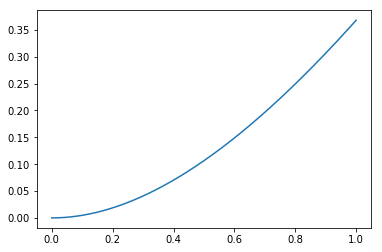

In [3]:
fun = exact_step_response(1.0, 1.0)

t = np.linspace(0.0, 1.0, 1000)
y = fun(t)


plt.plot(t, y)
plt.show()